# PeekingDuck

<img src="https://raw.githubusercontent.com/aimakerspace/PeekingDuck/dev/images/readme/peekingduck.png" width="240" height="240" align="center"/>


## Running PeekingDuck Python API

This Jupyter Notebook demonstrates what PeekingDuck models can do. We will be using computer vision models within peekingduck to infer on a sample image.

## Documentation

For more information on PeekingDuck, visit https://peekingduck.readthedocs.io/en/stable/

# 1 Prepare Jupyter Environment

### 1.1 Download Image

Download sample image and move it to the proper directory.

In [1]:
import urllib.request
url = 'https://raw.githubusercontent.com/aimakerspace/PeekingDuck/dev/images/testing/t1.jpg'
filename = 't1.jpg'
urllib.request.urlretrieve(url, filename)

('t1.jpg', <http.client.HTTPMessage at 0x7f77285b9850>)

In [2]:
%mkdir -p "data/input" "data/output"
%mv "t1.jpg" "data/input/t1.jpg"

### 1.2 Install PeekingDuck

Install peekingduck into python environment. Matplotlib is installed as a convenient library to show images in jupyter notebook.

In [3]:
%pip install peekingduck
%pip install matplotlib

     |████████████████████████████████| 156 kB 12.0 MB/s 
     |████████████████████████████████| 61 kB 369 kB/s 
     |████████████████████████████████| 636 kB 68.6 MB/s 
     |████████████████████████████████| 60 kB 6.4 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: tqdm
    Found existing installation: tqdm 4.62.3
    Uninstalling tqdm-4.62.3:
      Successfully uninstalled tqdm-4.62.3
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
panel 0.12.1 requires tqdm>=4.48.0, but you have tqdm 4.45.0 which is incompatible.
google-colab 1.0.0 requires requests~=2.23.0, but you 

## 2 Import PeekingDuck packages

Import necessary modules required to run peekingduck. These modules include the "runner" which runs the nodes. Other modules like "recorded", "yolo", "bbox", "media_writer" are considered "nodes" that manipulates data.

In [4]:
from peekingduck.runner import Runner
from peekingduck.pipeline.nodes.input import recorded
from peekingduck.pipeline.nodes.model import yolo
from peekingduck.pipeline.nodes.draw import bbox
from peekingduck.pipeline.nodes.output import media_writer

## 3 PeekingDuck Nodes

In PeekingDuck, all processes that does data processing are considered nodes. Subcategories include inputs, models, draw and output. These nodes takes incoming data (exception for input nodes) performs computation on this data and outputs results.

### 3.1 The initial image

The initial image is shown below. This image is loaded in using cv2 and is displayed using matplotlib.

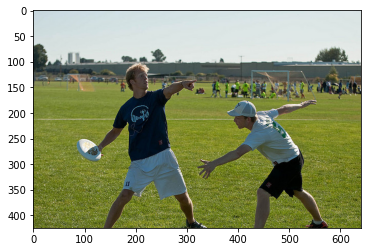

In [ ]:
import cv2
from matplotlib import pyplot as plt

%matplotlib inline
image = cv2.imread("data/input/t1.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)
plt.show()

### 3.2 Loading Nodes

Nodes like input and output are initialised with parameters. Some nodes like yolo and draw do not require additional parameters. However, nodes like recorded require `input_dir` to point to a media file while media_writer requires `output_dir`.

In [5]:
input_node = recorded.Node(input_dir="data/input/t1.jpg")
yolo_node = yolo.Node()
draw_node = bbox.Node()
output_node = media_writer.Node(output_dir="data/output")


8003it [00:47, 169.75it/s]
100%|██████████| 5/5 [00:02<00:00,  2.23it/s]


## 4 PeekingDuck Runner

The PeekingDuck Runner manages the running of individual nodes. It would run each node individually and sequentially, in the order which the nodes are passed. After the run, it is possible to retrieve inferrence results from the runner.

### 4.1 Initialise Runner and Run Nodes

Initialise the `Runner` and pass nodes as a list into the runner. This runner reads data provided by the input_node, performs inferrence using yolo (note: it download weights if not already existing), draws the bounding boxes and outputs the data into the filepath.

In [ ]:
runner = Runner(nodes=[input_node, yolo_node, draw_node, output_node])
runner.run()

### 4.2 Reading the output

This step reads the latest output and displays it using matplotlib.

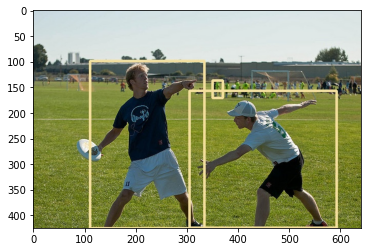

In [ ]:
import os
from pathlib import Path

p = Path(r'data/output').glob('*.jpg')
files = [f for f in p if f.is_file()]
files = sorted(files, key=os.path.getmtime)

%matplotlib inline
image = cv2.imread(str(files[-1]))
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)
plt.show()

### 4.3 Retrieve bbox information

If needed, it is possible to get data contained within the datapool `runner.pipeline.data`. This datapool records all data inferred from the run. As an object detection model outputs bounding boxes, there are 'bboxes', 'bbox_labels' and confidence scores ('bbox_scores') in the output.

In [ ]:
runner.pipeline.data

{'bbox_labels': array(['person', 'person', 'person'], dtype='<U6'),
 'bbox_scores': array([0.98604774, 0.8584354 , 0.2563716 ], dtype=float32),
 'bboxes': array([[0.4768853 , 0.36997905, 0.9254851 , 0.999221  ],
        [0.17411605, 0.2341345 , 0.5229075 , 1.        ],
        [0.5470805 , 0.32367244, 0.57856876, 0.40377304]], dtype=float32),
 'filename': 't1.jpg',
 'img': None,
 'pipeline_end': True,
 'saved_video_fps': 25.0}

If there is a need to get bbox locations can call it through its key.

In [ ]:
runner.pipeline.data["bboxes"]

array([[0.4768853 , 0.36997905, 0.9254851 , 0.999221  ],
       [0.17411605, 0.2341345 , 0.5229075 , 1.        ],
       [0.5470805 , 0.32367244, 0.57856876, 0.40377304]], dtype=float32)

## 5 Using Pose Estimation

PeekingDuck contains more than just object detection, it also contains other computer vision nodes like pose estimation. In this step we will use posenet to perform pose estimation.

### 5.1 Import and run pose estimation

In [ ]:
from peekingduck.pipeline.nodes.model import posenet
from peekingduck.pipeline.nodes.draw import poses

input_node = recorded.Node(input_dir="data/input/t1.jpg")
posenet_node = posenet.Node()
drawpose_node = poses.Node()

runner2 = Runner(nodes=[input_node, posenet_node, drawpose_node, output_node])
runner2.run()

---no posenet weights detected. proceeding to download...---


5007it [00:21, 229.25it/s]
100%|██████████| 24/24 [00:02<00:00,  9.67it/s]


---posenet weights download complete.---


/usr/local/lib/python3.7/dist-packages/peekingduck/pipeline/nodes/model/posenetv1/posenet_files/predictor.py:129: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  np.array(keypoint_conns)


### 5.2 Show results of Pose Estimation

The results of the model inferrence can be seen below. The yellow lines connect the (orange) keypoints within the image.

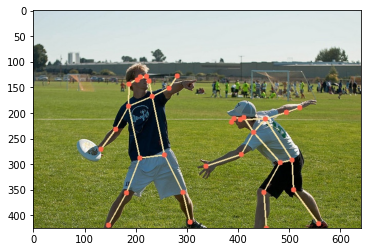

In [ ]:
p = Path(r'data/output').glob('*.jpg')
files = [f for f in p if f.is_file()]
files = sorted(files, key=os.path.getmtime)

%matplotlib inline
image = cv2.imread(str(files[-1]))
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)
plt.show()

### 5.3 Getting Locations of Joints

For the pose estimation model, it is possible to get the locations of the joints through the datapool "keypoints". To know more about model outputs visit our [documentation page](https://peekingduck.readthedocs.io/en/stable/peekingduck.pipeline.nodes.model.posenet.Node.html#peekingduck.pipeline.nodes.model.posenet.Node).

In [ ]:
runner2.pipeline.data["keypoints"][0]

array([[ 0.60548147,  0.51387652],
       [ 0.61299149,  0.49767775],
       [-1.        , -1.        ],
       [ 0.64354631,  0.49191946],
       [ 0.6323038 ,  0.50292889],
       [ 0.67188912,  0.56152492],
       [ 0.70821402,  0.49945098],
       [ 0.63464529,  0.66130557],
       [ 0.77247804,  0.46859816],
       [ 0.52753975,  0.71576123],
       [ 0.81264266,  0.44928622],
       [ 0.75370763,  0.70087477],
       [ 0.79061776,  0.68739311],
       [ 0.70323069,  0.8374809 ],
       [ 0.79462156,  0.82583587],
       [ 0.71235437,  1.        ],
       [ 0.87140444,  0.98062409]])

## 6 Summary

This demo illustrates the steps required to run PeekingDuck in jupyter notebook. It demonstrates the ability to run pose estimation and object detection through python package calls.

### Steps

1. Install PeekingDuck
2. Import required nodes
3. Input required filepaths
4. Run nodes using peekingduck.runner
5. Check your results in the output

In [ ]:
from peekingduck.pipeline.nodes.input import live

In [ ]:
input_node = live.Node(input_dir="data/input/t1.jpg")
posenet_node = posenet.Node()
drawpose_node = poses.Node()

runner2 = Runner(nodes=[input_node, posenet_node, drawpose_node, output_node])
runner2.run()